In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import json

config = json.load(open("config.json"))
N_CLASSES = config.get("N_CLASSES", 2)
N_POISONED_CLIENTS = config.get("N_POISONED_CLIENTS", 0)


In [39]:
import numpy as np
from scipy.optimize import curve_fit

# Example for Loss curve : Exponential Decay Function
    # L_max คือค่าสูงสุดที่ Curve จะเข้าใกล้ (asymptote) ซึ่งเป็นค่าคงที่เมื่อ x มีค่ามาก
    # A คือค่า amplitude หรือส่วนต่างระหว่างจุดเริ่มต้น (x=0) กับค่า asymptote
    # k คือค่า decay rate ซึ่งเป็นตัวกำหนดว่าการลดลงนั้นเร็วแค่ไหน (ยิ่ง k มีค่ามาก, การลดลงยิ่งเร็ว)
    # x คือตัวแปรอิสระ (เช่น เวลา, ระยะทาง, หรือจำนวนรอบ)
def loss_func(x, L_max, A, k):
    return L_max - A * np.exp(-k * x)


# Example for Accuracy curve : Inverted Logistic Function
    # L คือค่าสูงสุดของ curve (ในที่นี้คือ 1.0)
    # k คืออัตราการลดลง (ค่าติดลบแสดงถึงการลดลง)
    # x0 คือจุดกึ่งกลางที่ค่าลดลงถึงครึ่งหนึ่ง
def acc_func(x, L, k, x0):
    return L / (1 + np.exp(k * (x - x0)))


Mode: uniform
Loss function parameters: [1.37505722 1.28764266 0.00641505]
Accuracy function parameters: [ 1.00078391  0.7982013  99.02855865]
Mode: normal
Loss function parameters: [1.50630247 1.45208312 0.00577964]
Accuracy function parameters: [  0.99992521   2.01081568 100.65739374]
Mode: laplace
Loss function parameters: [1.41324849 1.33979122 0.0063167 ]
Accuracy function parameters: [ 0.99612375  3.13737203 98.36046694]
Mode: beta
Loss function parameters: [1.5622141  1.4540921  0.00520863]
Accuracy function parameters: [ 1.00030607  1.83148998 99.13542422]
Mode: triangular
Loss function parameters: [1.43436282 1.37249361 0.00622974]
Accuracy function parameters: [ 0.99986255  0.67514512 99.17912689]


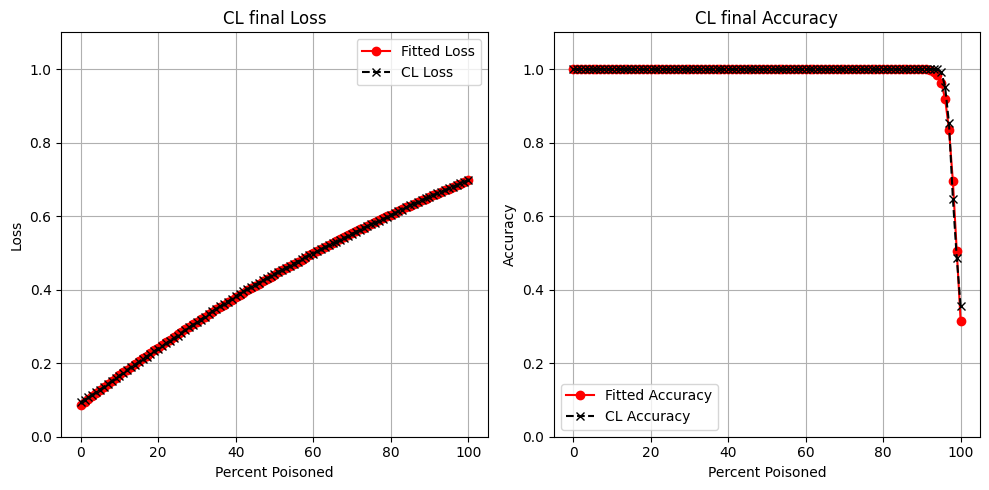

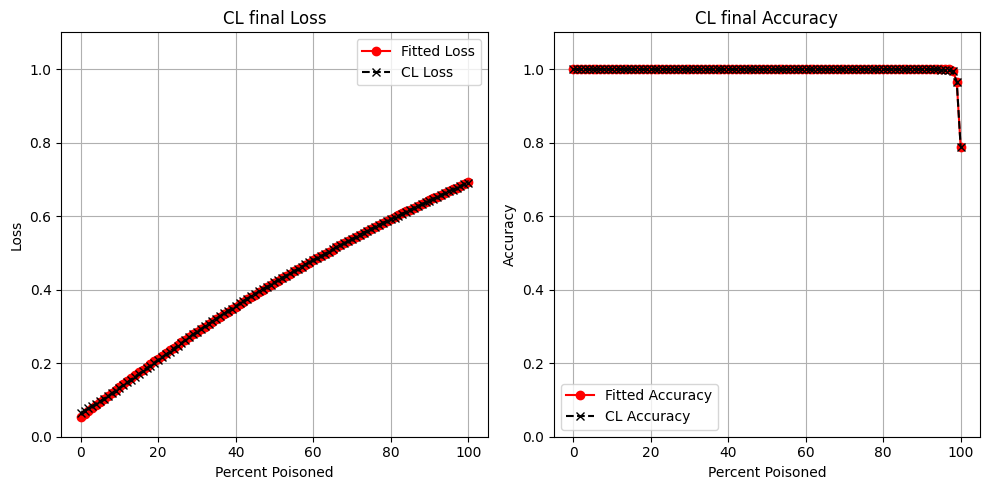

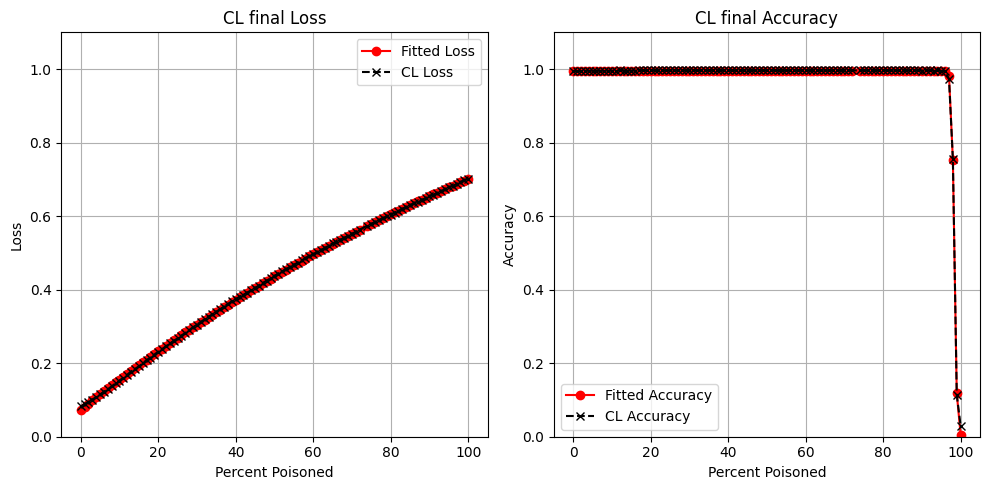

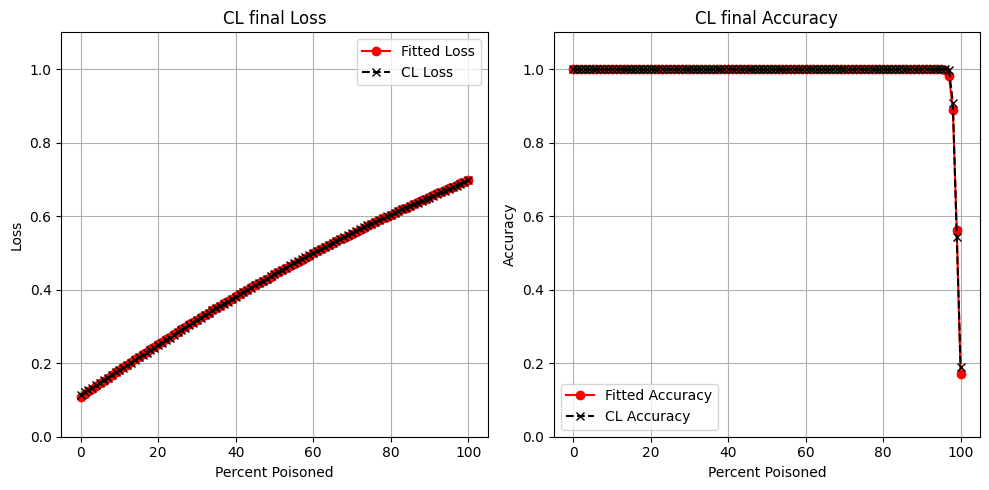

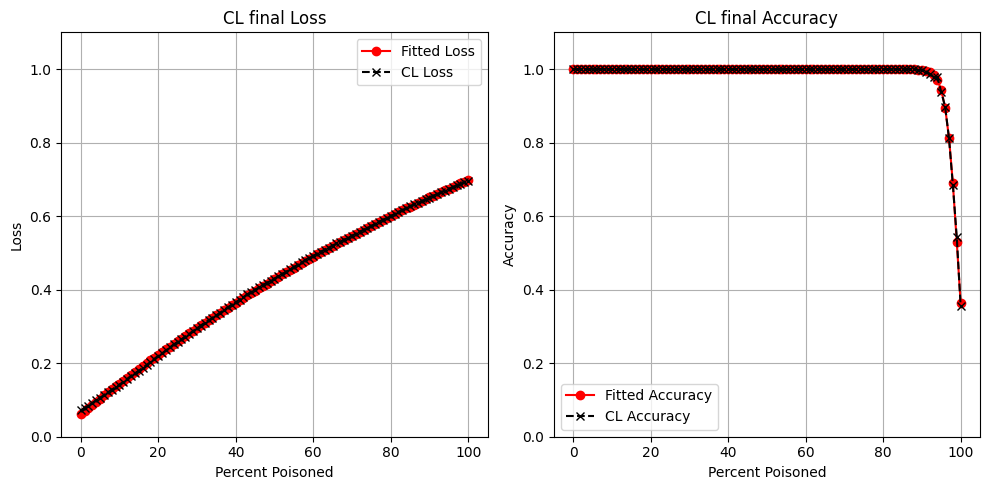

In [40]:

for mode in ['uniform', 'normal', 'laplace', 'beta', 'triangular']:
    df_list = []
    for i in range(101):
        try:
            csv_path = fr'results\ML101_linear_CL_batch\{mode}\poisoned_{i}\poisoned_{i}.csv'
            df = pd.read_csv(csv_path)
            df['poisoned'] = i
            df = df[['poisoned', 'loss', 'accuracy']]
            df_list.append(df.iloc[-1:, :])
        except Exception as e:
            df_list.append(pd.DataFrame({
                'poisoned': [i],
                'loss': [np.nan],
                'accuracy': [np.nan]
            }))
    df_all = pd.concat(df_list, ignore_index=True)
    df_all.to_csv(fr'results/ML101_linear_CL_batch_poisoned_{mode}.csv', index=False)
    # print(df_all)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharex=False)

    # All records up to current
    fit_df = df_all.replace([np.inf, -np.inf], np.nan).dropna(subset=['loss', 'accuracy'])
    poisoned = fit_df['poisoned'].to_numpy()
    losses = fit_df['loss'].to_numpy()
    accs = fit_df['accuracy'].to_numpy()

    # Fit with increased maxfev and initial guess
    params_loss, _ = curve_fit(loss_func, poisoned, losses, maxfev=5000, p0=[1, 1, 0.01])
    params_acc, _ = curve_fit(acc_func, poisoned, accs, maxfev=5000, p0=[1.0, -1.0, 98.0])
    print("======================================")
    print(f"Mode: {mode}")
    print(f"Loss function parameters: {params_loss}")
    print(f"Accuracy function parameters: {params_acc}")

    gen_loss = np.array([loss_func(x, *params_loss) for x in poisoned])
    gen_acc = np.array([acc_func(x, *params_acc) for x in poisoned])
    ax1.plot(poisoned, gen_loss, marker='o', color='red', label='Fitted Loss')
    ax2.plot(poisoned, gen_acc, marker='o', color='red', label='Fitted Accuracy')

    ax1.plot(poisoned, losses, marker='x', color='black', linestyle='--', label='CL Loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Percent Poisoned')
    ax1.set_title('CL final Loss')
    ax1.grid(True)
    ax1.set_ylim(0, 1.1)
    ax1.legend()

    ax2.plot(poisoned, accs, marker='x', color='black', linestyle='--', label='CL Accuracy')
    ax2.set_xlabel('Percent Poisoned')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('CL final Accuracy')
    ax2.grid(True)
    ax2.set_ylim(0, 1.1)
    ax2.legend()

    plt.tight_layout()
    save_name_path = fr'results/ML101_linear_CL_batch_poisoned_{mode}.jpg'
    plt.savefig(save_name_path)

Mode: uniform
Loss function parameters: [0.98931503 0.91207017 0.01088475]
Accuracy function parameters: [ 0.98917815  0.72075611 99.17578943]
Mode: normal
Loss function parameters: [1.27762258 1.23412442 0.00746972]
Accuracy function parameters: [ 1.30515488e+01  2.86616807e-04 -8.68373485e+03]
Mode: laplace
Loss function parameters: [2.02821425 1.95158861 0.00408125]
Accuracy function parameters: [ 0.96438744  4.07629227 98.29860188]
Mode: beta
Loss function parameters: [1.48167437 1.38054487 0.00582386]
Accuracy function parameters: [ 0.97422704  3.38392964 99.4017586 ]
Mode: triangular
Loss function parameters: [1.33982454 1.29455615 0.0075156 ]
Accuracy function parameters: [9.89384898e-01 7.31392257e-02 1.06446933e+02]


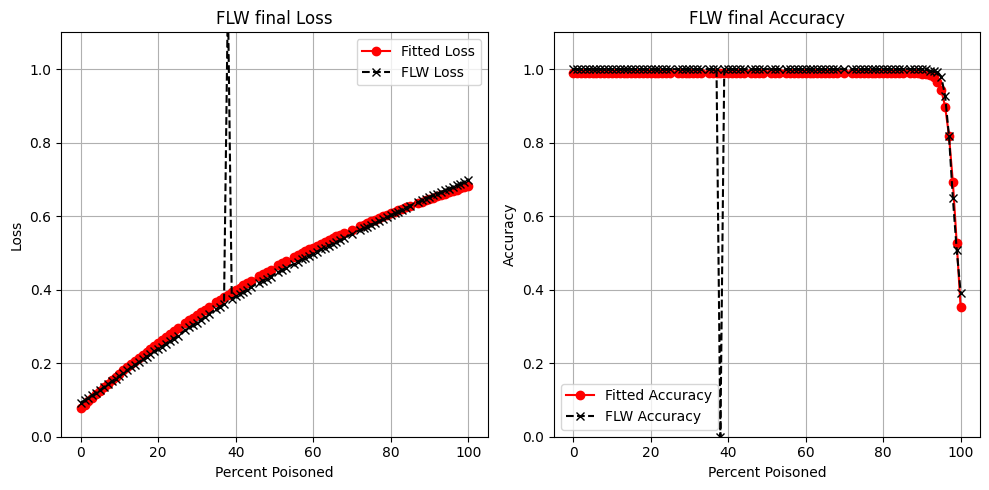

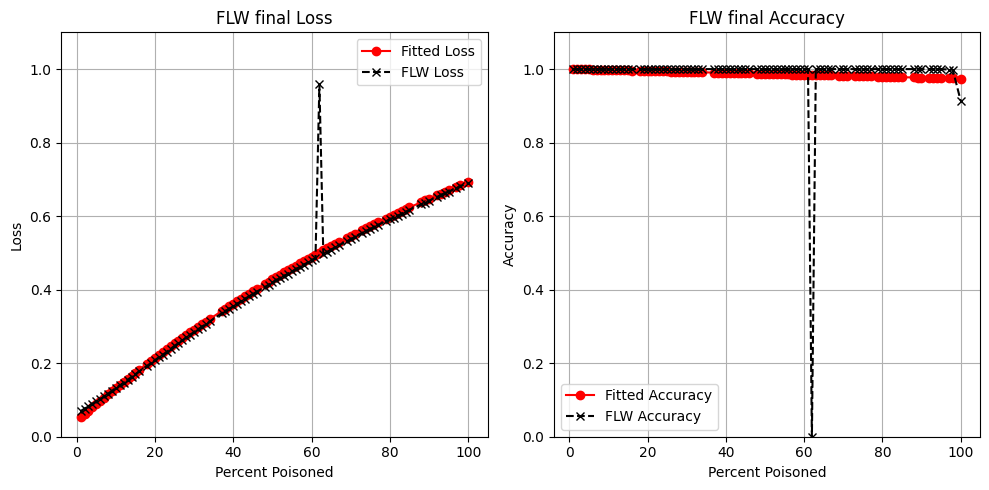

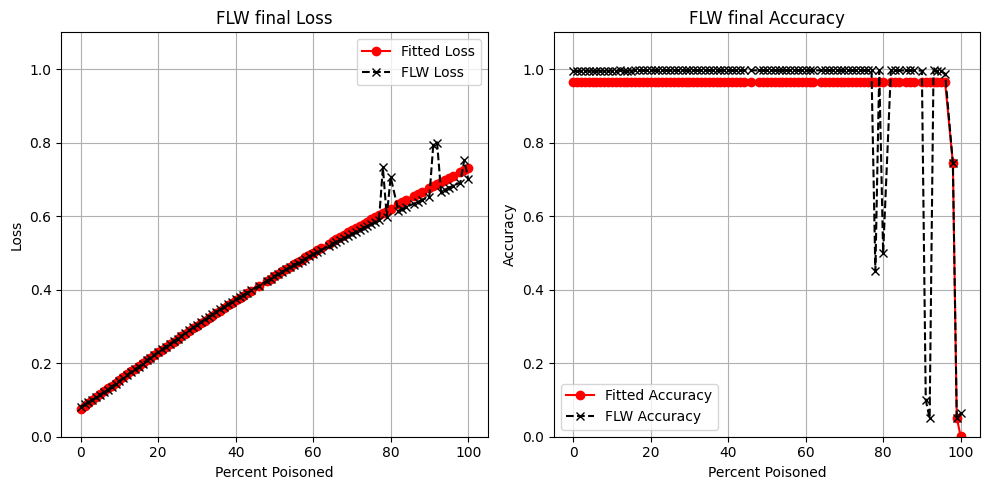

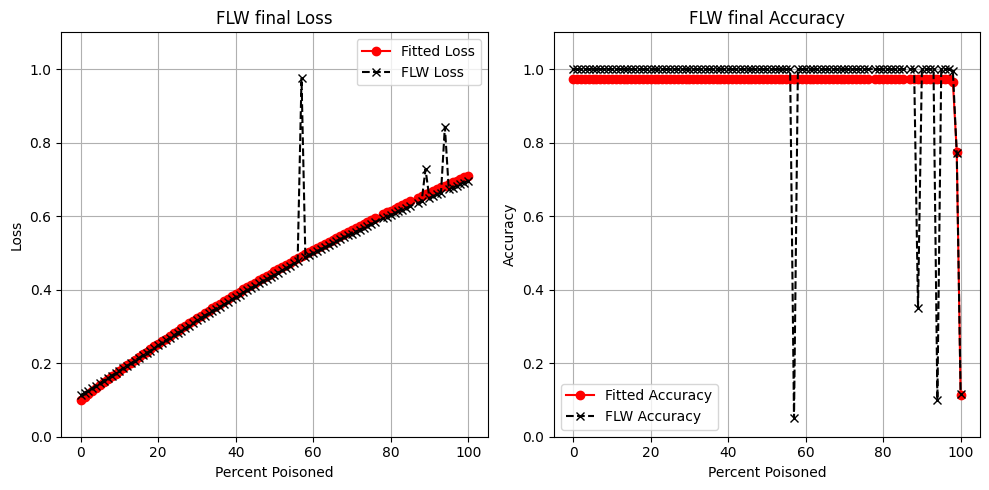

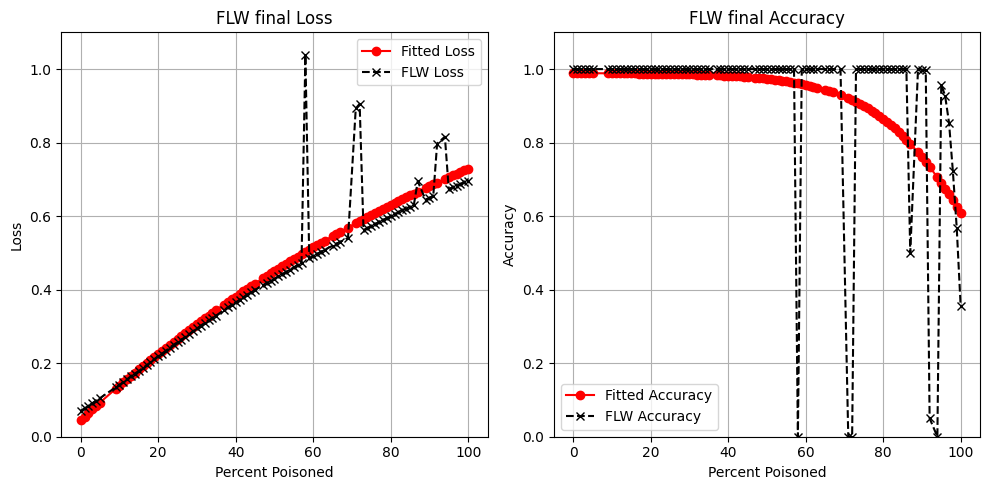

In [41]:

for mode in ['uniform', 'normal', 'laplace', 'beta', 'triangular']:
    df_list = []
    for i in range(101):
        try:
            csv_path = fr'results\ML302_linear_FLW_batch\{mode}\poisoned_{i}\poisoned_{i}.csv'
            df = pd.read_csv(csv_path)
            df['poisoned'] = i
            df = df[['poisoned', 'loss', 'accuracy']]
            df_list.append(df.iloc[-1:, :])
        except Exception as e:
            df_list.append(pd.DataFrame({
                'poisoned': [i],
                'loss': [np.nan],
                'accuracy': [np.nan]
            }))
    df_all = pd.concat(df_list, ignore_index=True)
    df_all.to_csv(fr'results/ML302_linear_FLW_batch_poisoned_{mode}.csv', index=False)
    # print(df_all)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharex=False)

    # All records up to current
    fit_df = df_all.replace([np.inf, -np.inf], np.nan).dropna(subset=['loss', 'accuracy'])
    poisoned = fit_df['poisoned'].to_numpy()
    losses = fit_df['loss'].to_numpy()
    accs = fit_df['accuracy'].to_numpy()

    # Fit with increased maxfev and initial guess
    params_loss, _ = curve_fit(loss_func, poisoned, losses, maxfev=5000, p0=[1, 1, 0.01])
    params_acc, _ = curve_fit(acc_func, poisoned, accs, maxfev=5000, p0=[1.0, -1.0, 98.0])
    print("======================================")
    print(f"Mode: {mode}")
    print(f"Loss function parameters: {params_loss}")
    print(f"Accuracy function parameters: {params_acc}")

    gen_loss = np.array([loss_func(x, *params_loss) for x in poisoned])
    gen_acc = np.array([acc_func(x, *params_acc) for x in poisoned])
    ax1.plot(poisoned, gen_loss, marker='o', color='red', label='Fitted Loss')
    ax2.plot(poisoned, gen_acc, marker='o', color='red', label='Fitted Accuracy')

    ax1.plot(poisoned, losses, marker='x', color='black', linestyle='--', label='FLW Loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Percent Poisoned')
    ax1.set_title('FLW final Loss')
    ax1.grid(True)
    ax1.set_ylim(0, 1.1)
    ax1.legend()

    ax2.plot(poisoned, accs, marker='x', color='black', linestyle='--', label='FLW Accuracy')
    ax2.set_xlabel('Percent Poisoned')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('FLW final Accuracy')
    ax2.grid(True)
    ax2.set_ylim(0, 1.1)
    ax2.legend()

    plt.tight_layout()
    save_name_path = fr'results/ML302_linear_FLW_batch_poisoned_{mode}.jpg'
    plt.savefig(save_name_path)
